# <center> LINMA2300 - Project 1 : Dimensionality reduction methods and nearest neighbor problem</center>

#### <center>18-10-2024 V1</center>


> Prof. Laurent Jacques, Bastien Massion, Nicolas Mil-Homens Cavaco



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import itertools
## Write your additional imports here

In [2]:
def color_generator():
    colors = ['#b694fa', '#87cefa', '#94faca', '#f2d9a6', '#8cf471', '#af002a', '#6474ed', '#2b4fe2', '#e22b8a', '#f0e58c', '#008080']
    return itertools.cycle(colors)

# gen = color_generator()
# color = next(gen)

In [3]:
# Estimation of the FLOPS on the machine

def benchmark_matrix_multiplication(n, repetitions=100):
    # Define matrix size
    A = np.random.rand(n, n)
    B = np.random.rand(n, n)
    
    total_time = 0
    for _ in range(repetitions):
        start_time = time.time()
        np.dot(A, B)
        end_time = time.time()
        
        total_time += end_time - start_time
    
    average_time_per_operation = total_time / (repetitions * (n * n * n))
    return average_time_per_operation

# Example usage
n = 1000
repetitions = 1000
operation_time = benchmark_matrix_multiplication(n, repetitions)
print(f"Average time per operation: {operation_time:.15f} seconds")

Average time per operation: 0.000000000028185 seconds


## 1. CIFAR-10 dataset

In [4]:
N = 8000
N_query = 100
n = 3*32*32
p = 32
d = 300

## Do not modify ##
N_batch  = 10000
N_test   = 10000
N_sample = 50000
## ############# ##

#### 1.1 Load data

In [5]:
## Load Dataset ##
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def extract_data_and_swap_axes(dataset):
    dataset = dataset[b'data'].reshape((N_batch, 3, p, p))
    dataset = np.swapaxes(dataset, 1, 3)
    dataset = np.swapaxes(dataset, 1, 2)
    return dataset

## Dataset 
list_batches = []
for i in range(5):
    dataset = unpickle(f"cifar-10-batches-py/data_batch_{i+1}")
    dataset = extract_data_and_swap_axes(dataset)
    list_batches.append(dataset)

## Test set
test_set = unpickle("cifar-10-batches-py/test_batch")
test_set = extract_data_and_swap_axes(test_set)

#### 1.2 Center data

In [6]:
## Centering data ##
X = np.array(list_batches).reshape(N_sample, p, p, 3) / 255
X = X.reshape(N_sample, n).T[:,:N]
mean_X = np.mean(X, axis=1)
X = X - mean_X[:,None]

## Centering test set ##
Q = test_set / 255
Q = Q.reshape(N_test, n).T[:,:N_query]
Q = Q - mean_X[:,None]

#### 1.3 Show samples

In [7]:
def show_samples_image(X, p=32, grid_dim=6, title=""):
    """
    Show samples of a dataset X of p x p images.
    @args:
        <numpy array> X: dataset.
        <int> p: dimension of an image.
        <int> grid_dim: dimension of the grid of samples displayed.
        <string> title: title of the grid.
    """
    Y = (X + mean_X[:,None]).reshape(p, p, 3, X.shape[1]) 
    fig, axes = plt.subplots(grid_dim,grid_dim)
    fig.suptitle(title)
    Y = Y - Y.min()
    Y = Y / Y.max()
    for i in range(grid_dim):
        for j in range(grid_dim):
            axes[i,j].imshow(Y[:,:,:,grid_dim*i+j])
            axes[i,j].axis("off")
    plt.show()

def show_image(x, p=32):
    """
    Show a p x p image.
    @args:
        <numpy array> x: image.
        <int> p: dimension of the image.
    """
    y = x.reshape(p, p, 3) 
    y = y - y.min()
    y = y / y.max()
    plt.figure(figsize=(1,1))
    plt.imshow(y)
    plt.axis("off")
    plt.show()
    


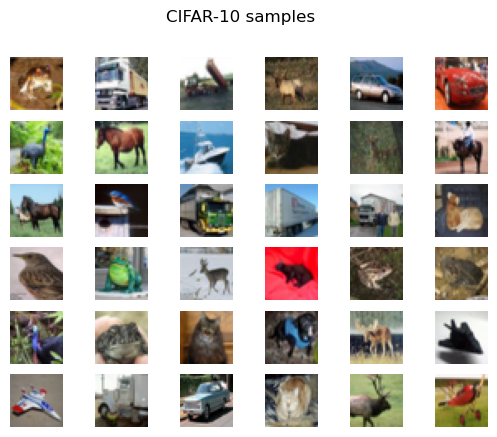

In [8]:
show_samples_image(X, title="CIFAR-10 samples")

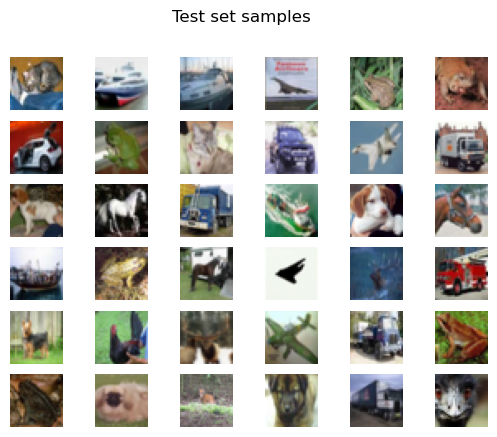

In [9]:
show_samples_image(Q, title="Test set samples")

## 2. Project

In [10]:
def projected_nearest_neighbor(X, Q):
    """
    Find the nearest neighbor in X for each query in Q using a memory-efficient approach.
    @args:
        <numpy array> X: dataset with shape (d,N).
        <numpy array> Q: query set with shape (d,N_query).
    """
    
    # Pre-allocate arrays for the nearest neighbors and their indices
    nearest_neighbors = np.zeros(Q.shape)
    indices = np.zeros(Q.shape[1], dtype=int)

    # Loop through each query
    for j in range(Q.shape[1]):
        q = Q[:, j]  # Extract the j-th query
        
        # Calculate distances between the query and all points in X
        distances = np.linalg.norm(X - q[:, np.newaxis], axis=0)
        
        # Find the index of the minimum distance
        i_star = np.argmin(distances)
        
        # Store the nearest neighbor and the index
        nearest_neighbors[:, j] = X[:, i_star]
        indices[j] = i_star

    return nearest_neighbors, indices

#====================================================================================================================================================================

def show_nearest_images(X, queries, nearest_neighbors, indices, p=32, pairs_per_row=5):
    """
    Display each query image next to its nearest neighbor from the dataset in a single figure with subplots.
    @args:
        <numpy array> X: dataset.
        <numpy array> queries: query set.
        <numpy array> nearest_neighbors: nearest neighbors of the queries.
        <list> indices: indices of the nearest neighbors.
        <int> p: dimension of the images (assumes square images).
        <int> pairs_per_row: number of query-nearest neighbor pairs to display per row.
    """
    num_queries = queries.shape[1]
    num_rows = (num_queries + pairs_per_row - 1) // pairs_per_row  # Calculate the total number of rows

    # Create a figure with 2 * pairs_per_row columns and num_rows rows
    fig, axes = plt.subplots(num_rows, pairs_per_row * 2, figsize=(3 * pairs_per_row, 3 * num_rows))
    fig.suptitle("Query Images and Their Nearest Neighbors", fontsize=16)
    
    for j in range(num_queries):
        row = j // pairs_per_row
        col = (j % pairs_per_row) * 2  # Each pair takes up 2 columns
        
        # Reshape and normalize images for display
        query_img = queries[:, j].reshape((p, p, 3))
        query_img = query_img - query_img.min()
        query_img = query_img / query_img.max()
        
        neighbor_img = nearest_neighbors[:, j].reshape((p, p, 3))
        neighbor_img = neighbor_img - neighbor_img.min()
        neighbor_img = neighbor_img / neighbor_img.max()
        
        # Display the query image
        axes[row, col].imshow(query_img)
        axes[row, col].set_title(f"Query {j+1}")
        axes[row, col].axis("off")
        
        # Display the nearest neighbor image
        axes[row, col + 1].imshow(neighbor_img)
        axes[row, col + 1].set_title(f"Neighbor (Index: {indices[j]})")
        axes[row, col + 1].axis("off")
    
    # Hide any unused subplots
    for j in range(num_queries, num_rows * pairs_per_row):
        row, col = j // pairs_per_row, (j % pairs_per_row) * 2
        axes[row, col].axis("off")
        axes[row, col + 1].axis("off")

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

#### 2.1 Identity projection

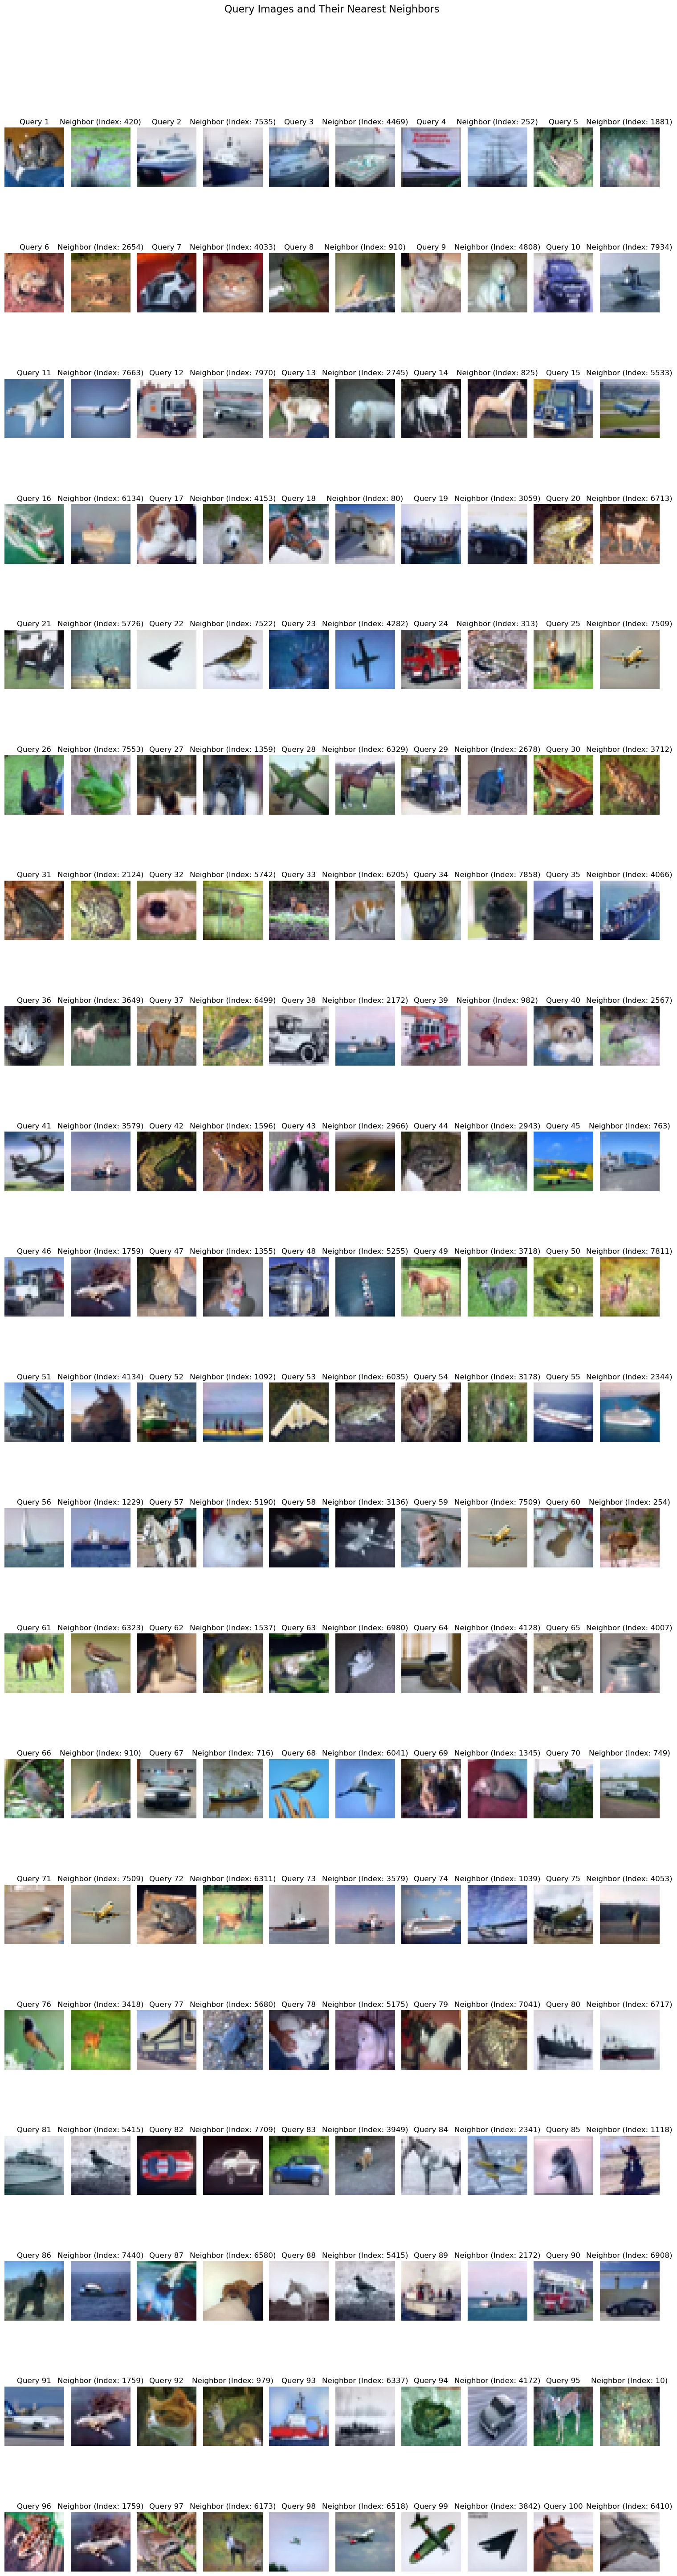

In [11]:
d = n
phi = np.identity(n)
X_prime = phi @ X
Q_prime = phi @ Q

nearest_neighbors_Id, indices_Id = projected_nearest_neighbor(X_prime, Q_prime)

show_nearest_images(X_prime, Q_prime, nearest_neighbors_Id, indices_Id, p=32)

As we iterate through all $q$ in $Q$, it multiplies the total complexity by $\mathcal{O}(N_{query})$.\
For each vector $q$, we must compare it to each of the $N$ images in $X$.\
This represents $d$ substractions (as the dimensionnality is reduced to $d$ before calling this function) followed by a scalar product ($d$ square, $d-1$ additions)\
$$\min_{i=1,...,N} \left\|X_{[:,i]} - q\right\|^2_2 = \min_{i=1,...,N} (X_{1,i} - q_1)^2 + ... + (X_{d,i} - q_d)^2$$
This is thus $N \times (2d + (d-1))$ operations which reduces to $\mathcal{O}(N \times d)$.\
Finding the minimum of those can be done in $\mathcal{O}(N)$.\
The final complexity thus reduces to $\mathcal{O}(N_{query} \times N \times d)$ operations. We just have to divide by the FLOPS of the machine to obtain the time complexity.

#### 2.2 PCA projection

In [12]:
U, __, __ = np.linalg.svd(X, full_matrices=False)
d = 300
U_d = U[:,:d]
phi = U_d.T
X_prime = phi @ X
Q_prime = phi @ Q

nearest_neighbors, indices = projected_nearest_neighbor(X_prime, Q_prime)

# show_nearest_images(X_prime, Q_prime, nearest_neighbors, indices, p=10)

From documentation, computing U using np.linalg.svd() typically requires $\mathcal{O}(min(N,n) \times N \times n)$ operations.\
The computation of $X' = \Phi X$ requires $\mathcal{O}(n \times N \times d)$\
The computation of $Q' = \Phi Q$ requires $\mathcal{O}(n \times N_{query} \times d)$

If we want to test multiples values for $d$ that we'll denote as $\hat{d}$, as we don't recompute the svd every time, the expected behaviour should be :\
$\mathcal{O}(n \times N \times \hat{d}) + \mathcal{O}(n \times N_{query} \times \hat{d}) + \mathcal{O}(N_{query} \times N \times \hat{d})$

In [13]:
def compute_diff_with_Id(indices, indices_Id):
    """
    Compute the number of times the nearest neighbor index is the same for the identity and the projection.
    @args:
        <list> indices: indices of the nearest neighbors after projection.
        <list> indices_Id: indices of the nearest neighbors without projection.
    @return:
        <int> count: number of times the indices are the same.
    """
    count = 0
    for i, j in zip(indices, indices_Id):
        if i == j:
            count += 1
    return count

Computing for d = 10
Computing for d = 20
Computing for d = 30
Computing for d = 40
Computing for d = 50
Computing for d = 60
Computing for d = 70
Computing for d = 80
Computing for d = 90
Computing for d = 100
Computing for d = 200
Computing for d = 300
Computing for d = 400
Computing for d = 500
Computing for d = 600
Computing for d = 700
Computing for d = 800
Computing for d = 900
Computing for d = 1000
Computing for d = 1100
Computing for d = 1200
Computing for d = 1300
Computing for d = 1400
Computing for d = 1500
Computing for d = 1600
Computing for d = 1700
Computing for d = 1800
Computing for d = 1900
Computing for d = 2000
Computing for d = 2100
Computing for d = 2200
Computing for d = 2300
Computing for d = 2400
Computing for d = 2500
Computing for d = 2600
Computing for d = 2700
Computing for d = 2800
Computing for d = 2900
Computing for d = 3000
Computing for d = 3072


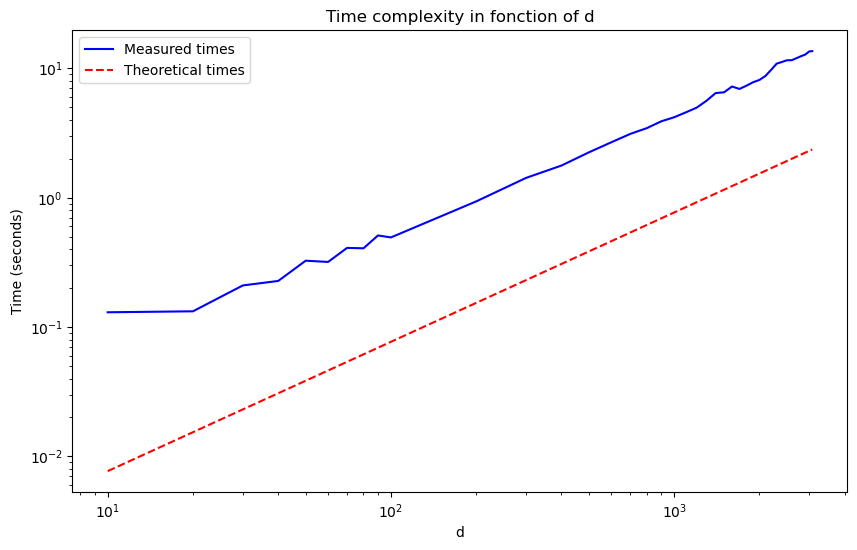

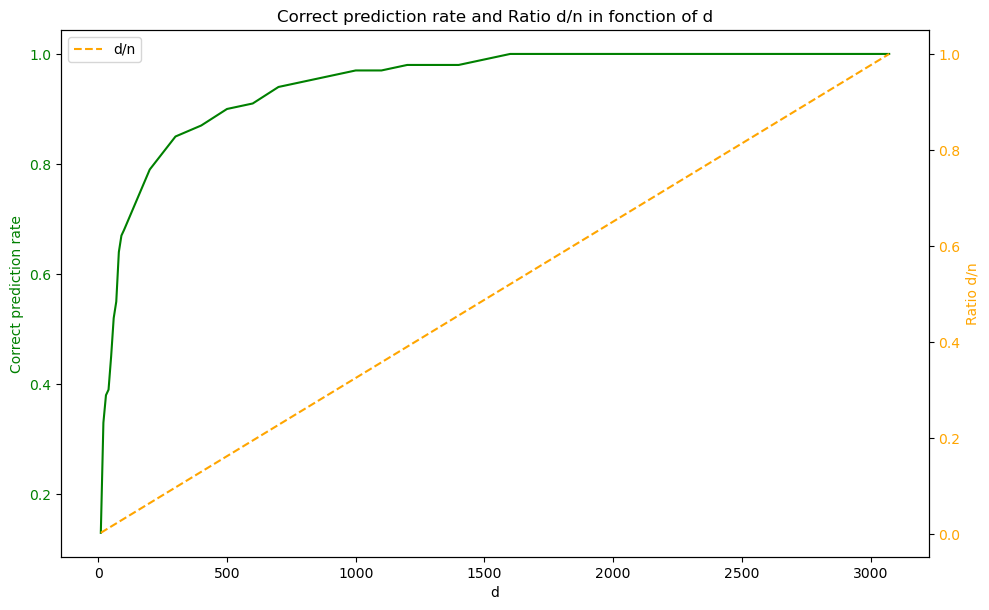

In [15]:
values_d = [10*i for i in range(1, 11)] + [100*i for i in range(2, 31)] + [3072]
times = []
theoretical_times = []
correct = []

for d_hat in values_d :
    print(f"Computing for d = {d_hat}")
    U_d = U[:,:d_hat]
    phi = U_d.T
    start = time.time()
    X_prime = phi @ X
    Q_prime = phi @ Q
    nearest_neighbors_PCA, indices_PCA = projected_nearest_neighbor(X_prime, Q_prime)
    end = time.time()
    times.append(end-start)
    
    time_for_X_prime = operation_time * (n * N * d_hat)
    time_for_Q_prime = operation_time * (n * N_query * d_hat)
    time_for_compute_distances = operation_time * N_query * (N * (2*d_hat + d_hat - 1))
    time_for_find_nearest = operation_time * N_query * N
    theoretical_times.append(time_for_X_prime + time_for_Q_prime + time_for_compute_distances + time_for_find_nearest)
    
    correct.append(compute_diff_with_Id(indices_PCA, indices_Id) / N_query)


plt.figure(figsize=(10, 6))
plt.loglog(values_d, times, label='Measured times', color='blue')
plt.loglog(values_d, theoretical_times, label='Theoretical times', color='red', linestyle='dashed')
plt.xlabel('d')
plt.ylabel('Time (seconds)')
plt.title('Time complexity in fonction of d')
plt.legend()

# Calculate the ratio d/n
ratio_dn = [d / n for d in values_d]
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('d')
ax1.set_ylabel('Correct prediction rate', color='green')
ax1.plot(values_d, correct, color='green', label='Nbr of correct / N_query')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Ratio d/n', color='orange')
ax2.plot(values_d, ratio_dn, color='orange', linestyle='dashed', label='d/n')
ax2.tick_params(axis='y', labelcolor='orange')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.title('Correct prediction rate and Ratio d/n in fonction of d')
plt.legend()
plt.show()

#### 2.3 Gaussian projection

In [ ]:
phi = np.random.normal(0, np.sqrt(1/d), (d, n))
X_prime = phi @ X
Q_prime = phi @ Q

nearest_neighbors, indices = projected_nearest_neighbor(X_prime, Q_prime)

#show_nearest_images(X_prime, Q_prime, nearest_neighbors, indices, p)

#### 2.4 A particular random projection

In [16]:
def matrix_vector_product(x, d, selected_indices = None):
    n = len(x)
    Fx = np.fft.fft(x)
    for i in range(n):
        if np.random.rand() < 1 / d:
            Fx[i] *= -1 
    FstarDFx = np.fft.ifft(Fx)

    if selected_indices is None:
        selected_indices = np.random.choice(n, d, replace=False)

    phi_vector = FstarDFx[selected_indices]
    
    return phi_vector, selected_indices

def projected_nearest_neighbor_modified(X,Q,d) :
    
    """
    Find the nearest neighbor in X for each query in Q using the projected nearest neighbor algorithm.
    @args:
        <numpy array> X: dataset.
        <numpy array> Q: query set (other images to find the nearest neighbor in X).
    """
    
    nearest_neighbors = []
    indices = []

    for j in range(Q.shape[1]) :
        q, selected_indices = matrix_vector_product(Q[:,j], d)
        for col_X in range(X.shape[1]) :
            x, __ = matrix_vector_product(X[:,col_X], d, selected_indices)
            if col_X == 0 :
                i_star = col_X
                min_norm = np.linalg.norm(x-q, ord=2)
            else :
                norm = np.linalg.norm(x-q, ord=2)
                if norm < min_norm :
                    i_star = col_X
                    min_norm = norm
                    
        nearest_neighbors.append(X[:,i_star])
        indices.append(i_star)
        
    return np.array(nearest_neighbors).T, indices